In [101]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import medfilt
from myterial import salmon

from fcutils.plot.figure import set_figure_subplots_aspect, clean_axes
from fcutils.maths import derivative

In [115]:
# Load trials
fld = Path("/Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Locomotion/analysis/behavior/jl_trials_cache")

# load all json files in fld
all_files = [f for f in fld.glob('*.json')]

# load all_json to a list of dict
trials = [json.load(open(f)) for f in all_files]

X, Y = np.hstack([t["x"] for t in trials]), np.hstack([t["y"] for t in trials]) 
speed = medfilt(np.hstack([t["speed"] for t in trials]), 21)
accel = derivative(speed)
angvel = medfilt(np.rad2deg(np.hstack([t["ω"] for t in trials])), 21)
angacc = derivative(angvel)

durations = np.hstack([t["duration"][0] for t in trials])



In [75]:
# make a function that adds a colorbar to a subplot
def add_colorbar(ax, im, cbar_label):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
    cbar.set_label(cbar_label)
    return cbar


def heatmap(ax, X, Y, Z, cmap, label, vmin=None, vmax=None):
    im = ax.hexbin(
        X, Y, Z, cmap=cmap, vmin=vmin, vmax=vmax, gridsize=(40, 60),
    )
    add_colorbar(ax, im, label)
    ax.axis("equal")
    ax.axis("off")

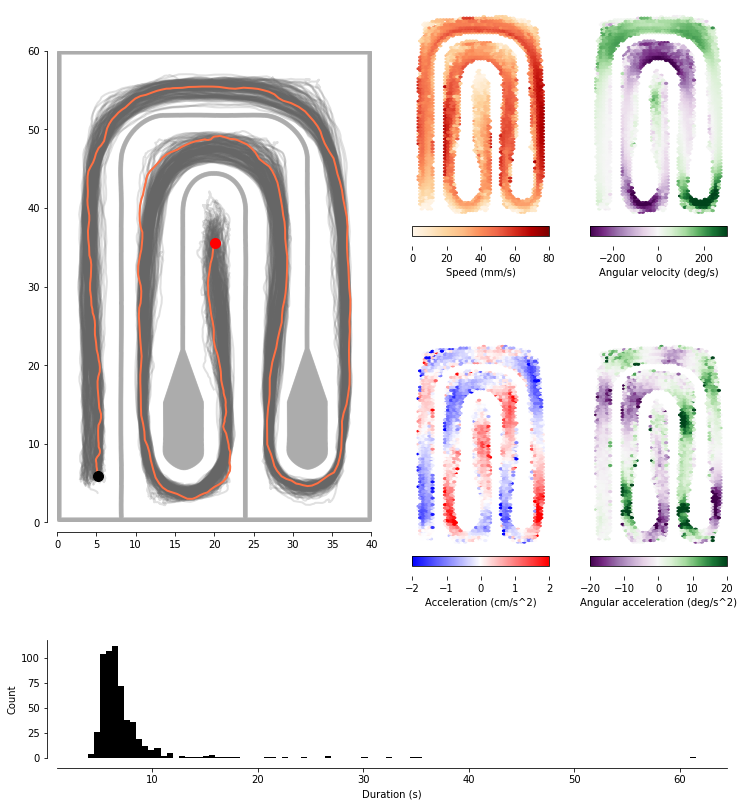

In [117]:
fig = plt.figure(figsize=(12, 12))
axes = fig.subplot_mosaic(
"""
    AABC
    AABC
    AADE
    AADE
    FFFF
"""
)
set_figure_subplots_aspect(    left=0.125, right=0.9, bottom=0.06, top=0.96, wspace=0.3, hspace=0.4)


# load image
img = plt.imread("/Users/federicoclaudi/Documents/Github/LocomotionControl/analysis/behavior/src/Hairpin.png")
axes["A"].imshow(img, extent=[0, 40, 0, 60])

# plot trials traces
for i in range(200):
    # plot trial X, Y
    axes["A"].plot(trials[i]["x"], trials[i]["y"], color=[.4, .4, .4], lw=2, alpha=0.2)
axes["A"].plot(trials[25]["x"], trials[25]["y"], color=salmon, lw=2, alpha=1)
axes["A"].scatter(trials[25]["x"][0], trials[25]["y"][0], color="red", s=100, zorder=1000)
axes["A"].scatter(trials[25]["x"][-1], trials[25]["y"][-1], color="black", s=100, zorder=1000)


# heatmaps
heatmap(axes["B"], X, Y, speed, "OrRd", "Speed (mm/s)", vmin=0, vmax=80)
heatmap(axes["C"], X, Y, angvel, "PRGn", "Angular velocity (deg/s)", vmin=-300, vmax=300)
heatmap(axes["D"], X, Y, accel, "bwr", "Acceleration (cm/s^2)", vmin=-2, vmax=2)
heatmap(axes["E"], X, Y, angacc, "PRGn", "Angular acceleration (deg/s^2)", vmin=-20, vmax=20)

# plot histogram of trials durations on ax F
axes["F"].hist(durations, bins=100, color="black", alpha=1)
_ = axes["F"].set(xlabel="Duration (s)", ylabel="Count")
clean_axes(fig)

